In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler 
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("dane-13-06-2-21.csv",index_col=1)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    source: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def df_lag(i,o,X_train,X_test,Y_train,Y_test,lstm):
    X_train=series_to_supervised(X_train,i,o).values
    X_test=series_to_supervised(X_test,i,o).values
    Y_train=Y_train[i:len(Y_train)-o+1]
    Y_test=Y_test[i:len(Y_test)-o+1]
    oversample = RandomOverSampler(sampling_strategy=0.3)
    X_train, Y_train = oversample.fit_resample(X_train, Y_train)
    if lstm==True:
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return [X_train,X_test,Y_train,Y_test]

In [5]:
def data_cl(data,n_in,n_out,turbine,lstm=False,time_window=72):
    data=data.drop(columns=["Unnamed: 0","Time_ID"])
    data=data[data.Turbine_ID==turbine]
    data["Efficiency"]=round(data['Grd_Prod_Pwr_Avg']/data['Predicted_power'],2)
    columns=['Grd_Prod_Pwr_Avg', 'Amb_WindSpeed_Avg', 'Amb_Temp_Avg',
           'Nac_Temp_Avg', 'Rtr_RPM_Avg', 'Gear_Bear_Temp_Avg', 'Gen_RPM_Avg',
           'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg', 'Amb_WindDir_Relative_Avg']
    data.loc[:,columns]=1-data.loc[:,columns].div(data["Predicted_power"],axis=0)
    data["Failure_window"]=0
    data.loc[data[data.Time_to_failure<time_window].index,"Failure_window"]=1
    data.sort_index(inplace=True)
    X=data.iloc[:,[1,2,3,4,5,6,7,8,9,10,16,17]]
    y=data.iloc[:,18]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    df=df_lag(n_in,n_out,X_train,X_test,y_train,y_test,lstm)
    return df

# Xgboost

In [15]:
def xgbcl(X_train,X_test,y_train,y_test,n_est=100,eta=0.3,max_depth=6,gamma=1):
    model=xgb.XGBClassifier(eta=eta,n_estimators=n_est,max_depth=max_depth,gamma=gamma)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train,y_train,eval_metric=["error", "logloss"],eval_set=eval_set)
    y_hat=model.predict(X_test)
    #print("Parametry: n_est = ",n_est)
    #print("eta = ",eta)
    #print("max_depth =",max_depth)
    #print("gamma = ", gamma)
    print("AUC:",roc_auc_score(y_test,y_hat))
    print("Accuracy:",accuracy_score(y_test,y_hat))
    print("Accuracy_trening:",accuracy_score(y_train,model.predict(X_train)))
    print("AUC_trening:",roc_auc_score(y_train,model.predict(X_train)))
    y_test=y_test.reset_index(drop=True)
    print("% dobrze przewidzianych awarii:",round(y_hat[y_test[y_test>0].index].sum()/len(y_hat[y_test[y_test>0].index]),2)*100)
    print("l błędnie przewidzianych awarii:",y_hat.sum()-y_hat[y_test[y_test==0].index].sum())
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    print(turbine)
 
    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss ' + turbine)
    plt.show()

    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Validation')
    ax.legend()
    
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error '+turbine)
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


T11
[0]	validation_0-error:0.094053	validation_0-logloss:0.625366	validation_1-error:0.015802	validation_1-logloss:0.615809
[1]	validation_0-error:0.094053	validation_0-logloss:0.570053	validation_1-error:0.015802	validation_1-logloss:0.551703
[2]	validation_0-error:0.094053	validation_0-logloss:0.523804	validation_1-error:0.015802	validation_1-logloss:0.498205
[3]	validation_0-error:0.094053	validation_0-logloss:0.48482	validation_1-error:0.015802	validation_1-logloss:0.452627
[4]	validation_0-error:0.094053	validation_0-logloss:0.451228	validation_1-error:0.015802	validation_1-logloss:0.412873
[5]	validation_0-error:0.094053	validation_0-logloss:0.413445	validation_1-error:0.015802	validation_1-logloss:0.375041
[6]	validation_0-error:0.094053	validation_0-logloss:0.381576	validation_1-error:0.015802	validation_1-logloss:0.342594
[7]	validation_0-error:0.094053	validation_0-logloss:0.358514	validation_1-error:0.015802	validation_1-logloss:0.315929
[8]	validation_0-error:0.023809	valid

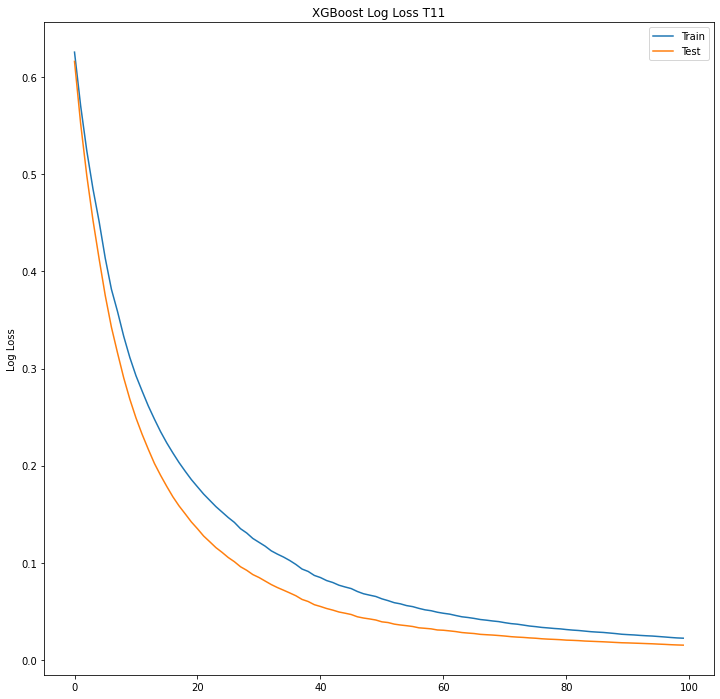

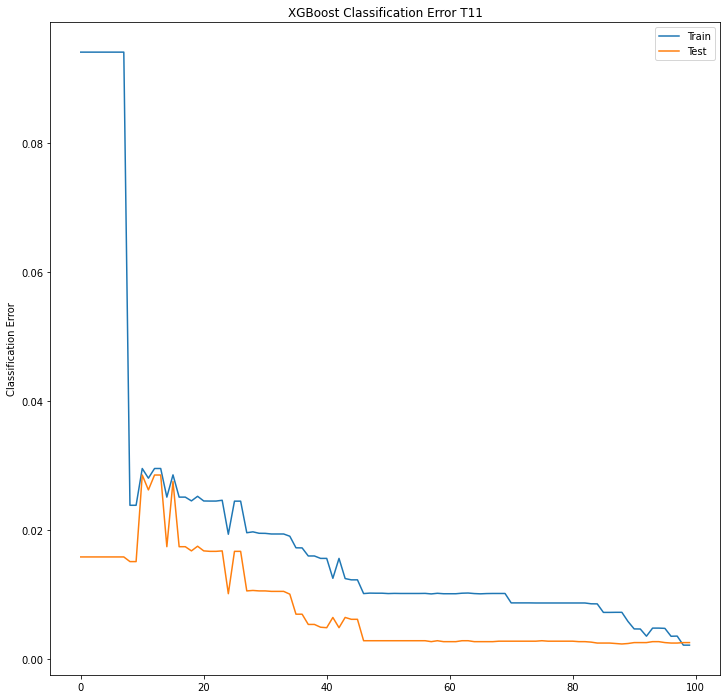

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


T06
[0]	validation_0-error:0.191581	validation_0-logloss:0.64742	validation_1-error:0.121445	validation_1-logloss:0.630717
[1]	validation_0-error:0.185555	validation_0-logloss:0.609792	validation_1-error:0.106818	validation_1-logloss:0.578626
[2]	validation_0-error:0.179191	validation_0-logloss:0.579319	validation_1-error:0.095979	validation_1-logloss:0.534697
[3]	validation_0-error:0.179191	validation_0-logloss:0.552021	validation_1-error:0.095979	validation_1-logloss:0.496787
[4]	validation_0-error:0.181488	validation_0-logloss:0.530453	validation_1-error:0.084499	validation_1-logloss:0.464042
[5]	validation_0-error:0.160807	validation_0-logloss:0.510212	validation_1-error:0.082051	validation_1-logloss:0.435418
[6]	validation_0-error:0.168782	validation_0-logloss:0.493837	validation_1-error:0.020338	validation_1-logloss:0.409955
[7]	validation_0-error:0.144373	validation_0-logloss:0.478125	validation_1-error:0.040385	validation_1-logloss:0.387842
[8]	validation_0-error:0.15691	valida

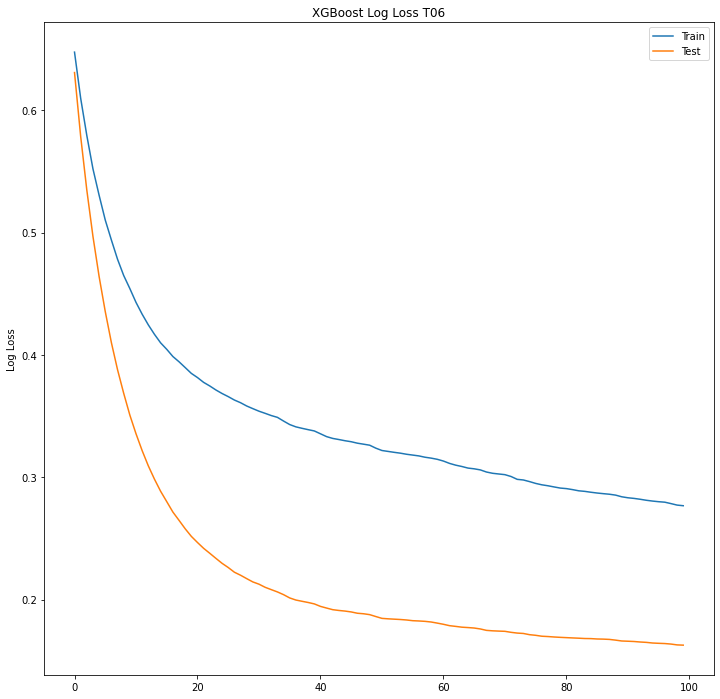

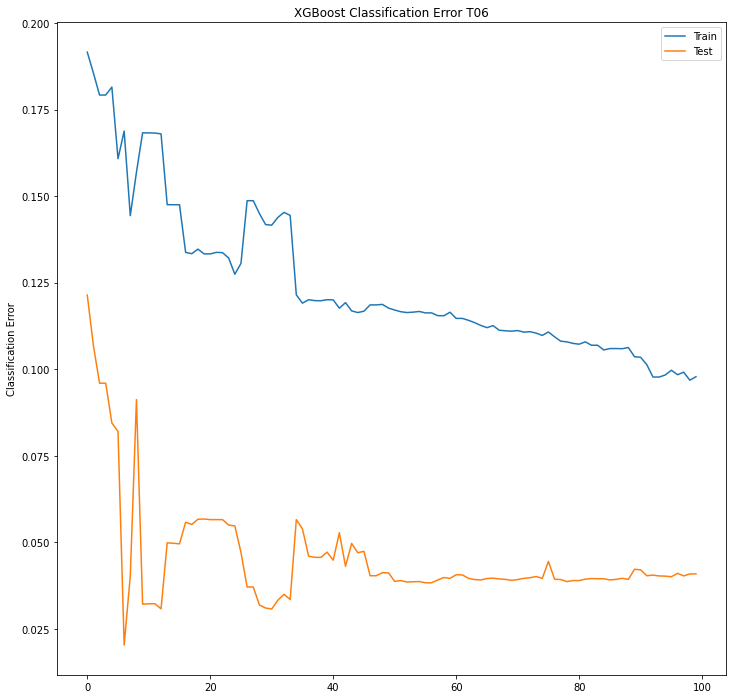

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


T01
[0]	validation_0-error:0.053354	validation_0-logloss:0.614095	validation_1-error:0.054798	validation_1-logloss:0.609617
[1]	validation_0-error:0.053354	validation_0-logloss:0.549931	validation_1-error:0.054798	validation_1-logloss:0.541598
[2]	validation_0-error:0.053354	validation_0-logloss:0.496794	validation_1-error:0.054798	validation_1-logloss:0.485298
[3]	validation_0-error:0.053354	validation_0-logloss:0.451501	validation_1-error:0.054798	validation_1-logloss:0.437942
[4]	validation_0-error:0.053354	validation_0-logloss:0.41348	validation_1-error:0.054798	validation_1-logloss:0.397885
[5]	validation_0-error:0.053354	validation_0-logloss:0.37759	validation_1-error:0.054798	validation_1-logloss:0.36178
[6]	validation_0-error:0.053354	validation_0-logloss:0.349024	validation_1-error:0.054798	validation_1-logloss:0.332186
[7]	validation_0-error:0.053354	validation_0-logloss:0.321421	validation_1-error:0.054798	validation_1-logloss:0.304315
[8]	validation_0-error:0.053354	validat

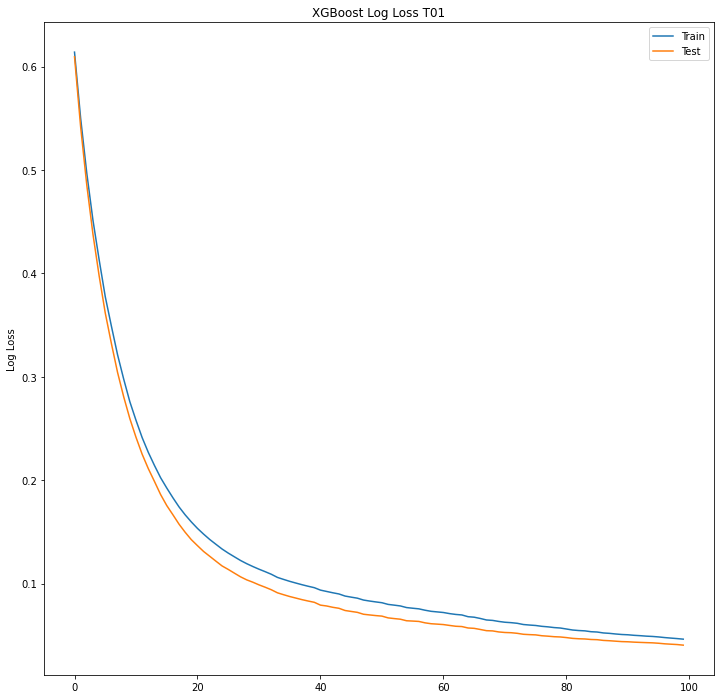

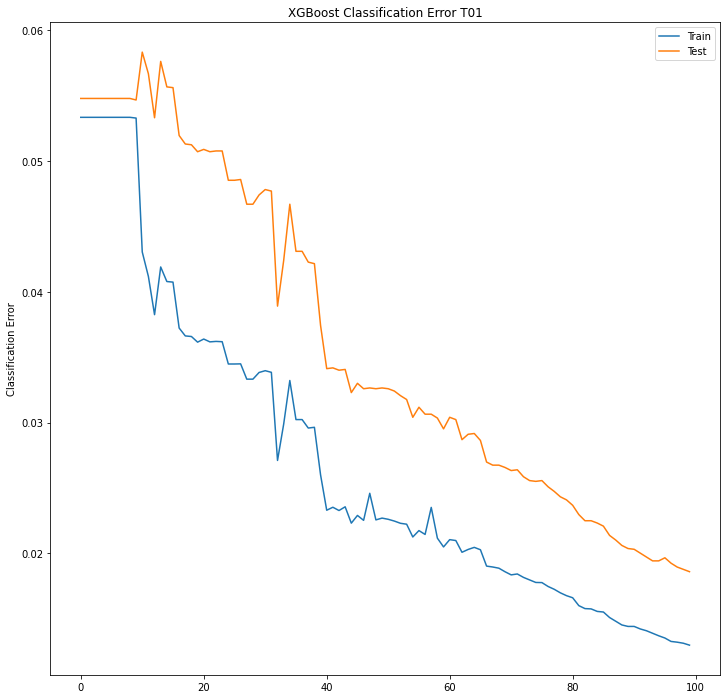

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


T09
[0]	validation_0-error:0.147676	validation_0-logloss:0.638653	validation_1-error:0.036681	validation_1-logloss:0.624222
[1]	validation_0-error:0.147676	validation_0-logloss:0.593474	validation_1-error:0.036681	validation_1-logloss:0.566856
[2]	validation_0-error:0.147676	validation_0-logloss:0.556066	validation_1-error:0.036681	validation_1-logloss:0.518137
[3]	validation_0-error:0.147676	validation_0-logloss:0.524004	validation_1-error:0.036681	validation_1-logloss:0.476318
[4]	validation_0-error:0.143683	validation_0-logloss:0.496825	validation_1-error:0.030182	validation_1-logloss:0.4403
[5]	validation_0-error:0.142823	validation_0-logloss:0.473018	validation_1-error:0.030627	validation_1-logloss:0.409359
[6]	validation_0-error:0.142823	validation_0-logloss:0.452791	validation_1-error:0.030627	validation_1-logloss:0.381739
[7]	validation_0-error:0.146024	validation_0-logloss:0.435	validation_1-error:0.016026	validation_1-logloss:0.358166
[8]	validation_0-error:0.142823	validatio

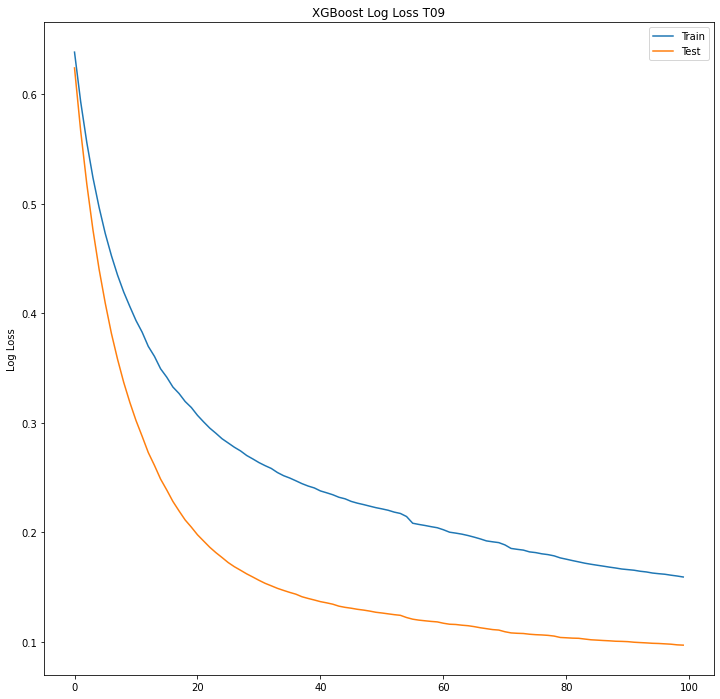

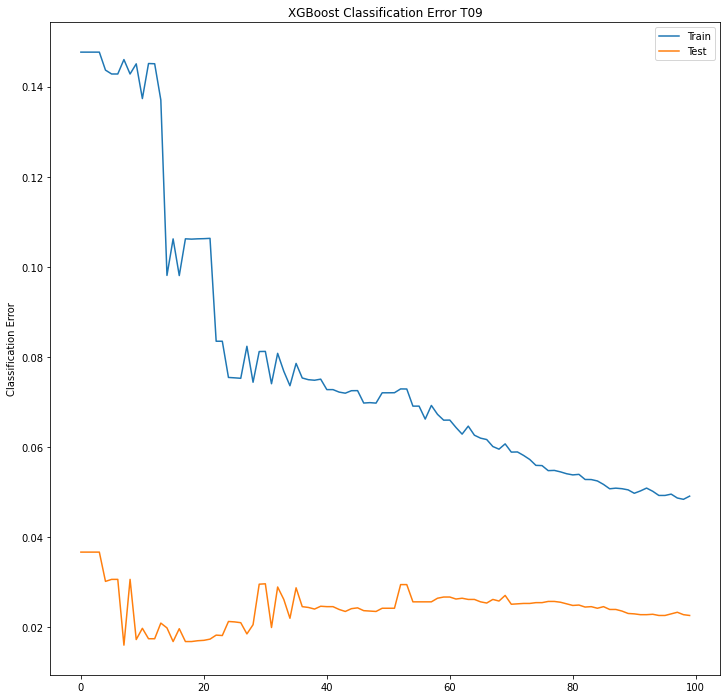

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


T07
[0]	validation_0-error:0.091033	validation_0-logloss:0.624017	validation_1-error:0.108505	validation_1-logloss:0.61592
[1]	validation_0-error:0.091033	validation_0-logloss:0.567542	validation_1-error:0.108505	validation_1-logloss:0.553277
[2]	validation_0-error:0.069983	validation_0-logloss:0.521283	validation_1-error:0.079536	validation_1-logloss:0.499731
[3]	validation_0-error:0.069983	validation_0-logloss:0.481945	validation_1-error:0.079536	validation_1-logloss:0.454812
[4]	validation_0-error:0.069983	validation_0-logloss:0.445723	validation_1-error:0.079536	validation_1-logloss:0.415759
[5]	validation_0-error:0.070274	validation_0-logloss:0.416565	validation_1-error:0.080116	validation_1-logloss:0.382025
[6]	validation_0-error:0.073358	validation_0-logloss:0.390684	validation_1-error:0.040406	validation_1-logloss:0.353087
[7]	validation_0-error:0.073358	validation_0-logloss:0.365896	validation_1-error:0.040406	validation_1-logloss:0.32716
[8]	validation_0-error:0.073358	valida

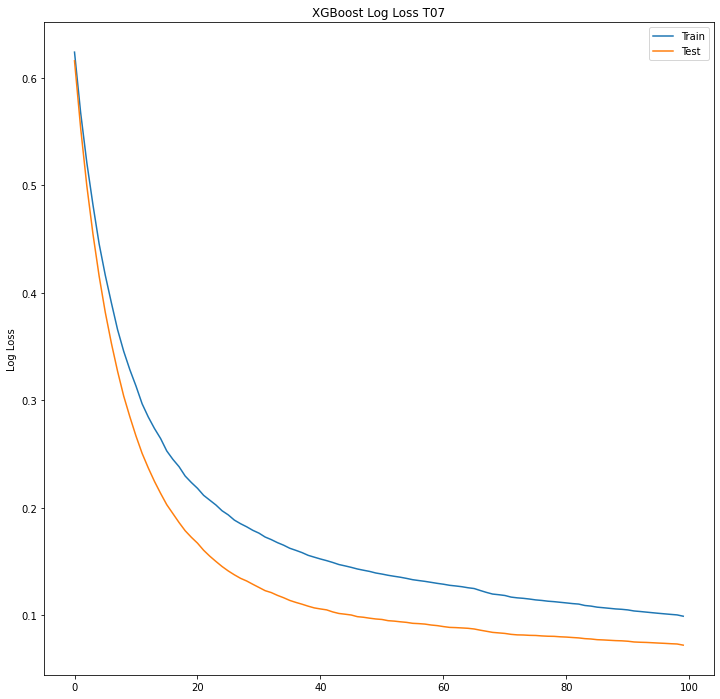

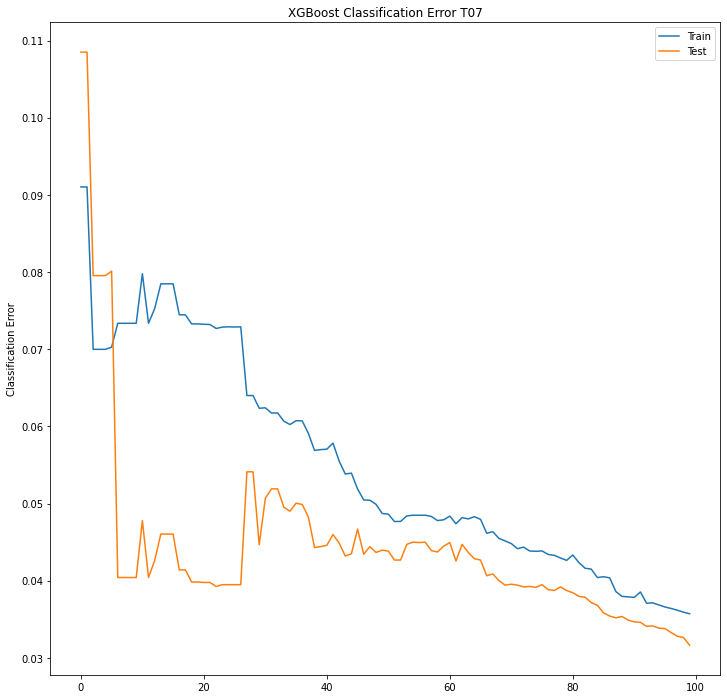

In [ ]:
turbines=data.Turbine_ID.unique()
for turbine in list(turbines):
    data_=data_cl(data,12,6,turbine,False,72)
    X_train=data_[0]
    X_test=data_[1]
    y_train=data_[2]
    y_test=data_[3]
    xgbcl(X_train,X_test,y_train,y_test,100,0.01,2,1)



# LSTM

In [13]:
def LSTMcl(X_train,X_test,y_train,y_test):
    opt = Adam(learning_rate=0.001)
    model = Sequential()
    model.add((LSTM(15, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Dense(5,activation="relu"))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics="accuracy")
    history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    plt.ylabel('Binary crossentropy',fontsize=24)
    plt.title('LSTM classification '+turbine, fontsize=30)
    plt.xlabel('Epoch', fontsize=24)
    ax.legend(fontsize=24)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.show()

    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Validation')
    plt.ylabel('Accuracy',fontsize=24)
    plt.title('LSTM classification '+turbine,fontsize=30)
    plt.xlabel('Epoch', fontsize=24)
    ax.legend(fontsize=24)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.show()


Epoch 1/10
719/719 [==============================] - 3s 3ms/step - loss: 2.8560 - accuracy: 0.7636 - val_loss: 0.0539 - val_accuracy: 0.9973
Epoch 2/10
719/719 [==============================] - 1s 2ms/step - loss: 0.8876 - accuracy: 0.7698 - val_loss: 0.0833 - val_accuracy: 0.9974
Epoch 3/10
719/719 [==============================] - 1s 2ms/step - loss: 1.1427 - accuracy: 0.7724 - val_loss: 0.1817 - val_accuracy: 0.9974
Epoch 4/10
719/719 [==============================] - 1s 2ms/step - loss: 0.7347 - accuracy: 0.7686 - val_loss: 0.1458 - val_accuracy: 0.9974
Epoch 5/10
719/719 [==============================] - 1s 2ms/step - loss: 1.1494 - accuracy: 0.7682 - val_loss: 0.2008 - val_accuracy: 0.9974
Epoch 6/10
719/719 [==============================] - 1s 2ms/step - loss: 0.4694 - accuracy: 0.7687 - val_loss: 0.2069 - val_accuracy: 0.9974
Epoch 7/10
719/719 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.7700 - val_loss: 0.2414 - val_accuracy: 0.9974
Epoch 

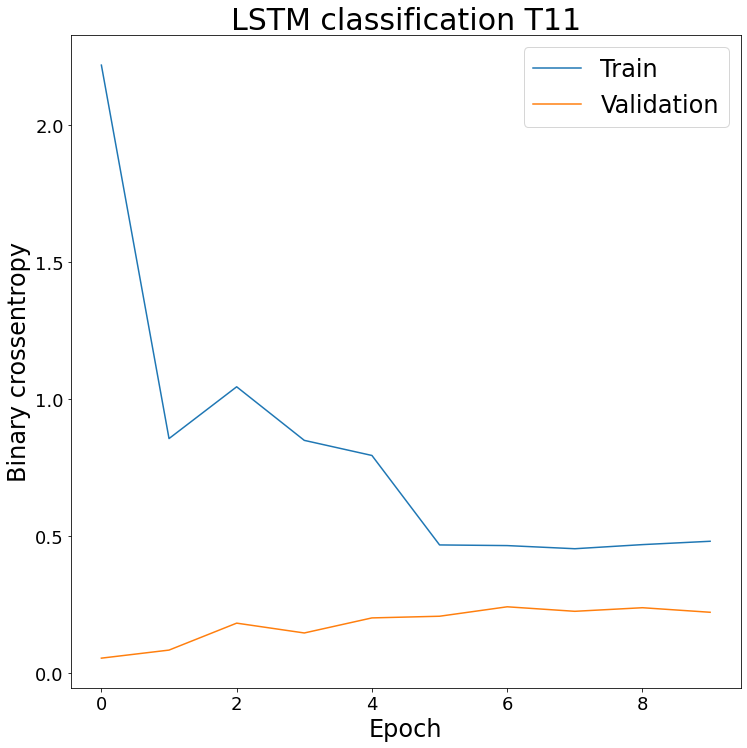

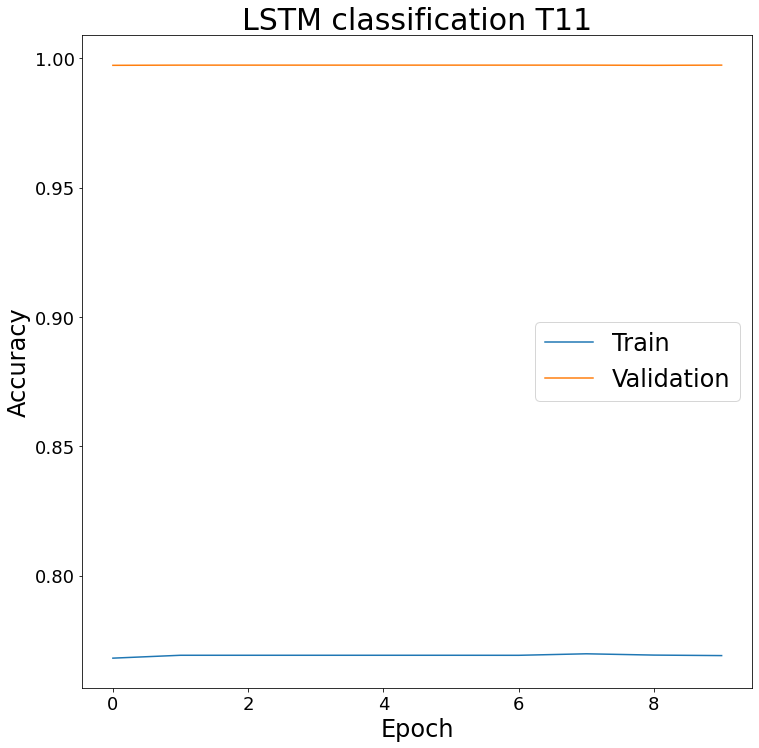

Epoch 1/10
888/888 [==============================] - 5s 4ms/step - loss: 0.9595 - accuracy: 0.7585 - val_loss: 0.2412 - val_accuracy: 0.9912
Epoch 2/10
888/888 [==============================] - 2s 2ms/step - loss: 0.5381 - accuracy: 0.7705 - val_loss: 0.2696 - val_accuracy: 0.9925
Epoch 3/10
888/888 [==============================] - 2s 2ms/step - loss: 0.5377 - accuracy: 0.7684 - val_loss: 0.2605 - val_accuracy: 0.9932
Epoch 4/10
888/888 [==============================] - 2s 2ms/step - loss: 0.5307 - accuracy: 0.7712 - val_loss: 0.2653 - val_accuracy: 0.9931
Epoch 5/10
888/888 [==============================] - 2s 2ms/step - loss: 0.5321 - accuracy: 0.7689 - val_loss: 0.2587 - val_accuracy: 0.9932
Epoch 6/10
888/888 [==============================] - 2s 2ms/step - loss: 0.5191 - accuracy: 0.7718 - val_loss: 0.2492 - val_accuracy: 0.9932
Epoch 7/10
888/888 [==============================] - 1s 2ms/step - loss: 0.5067 - accuracy: 0.7726 - val_loss: 0.2633 - val_accuracy: 0.9761
Epoch 

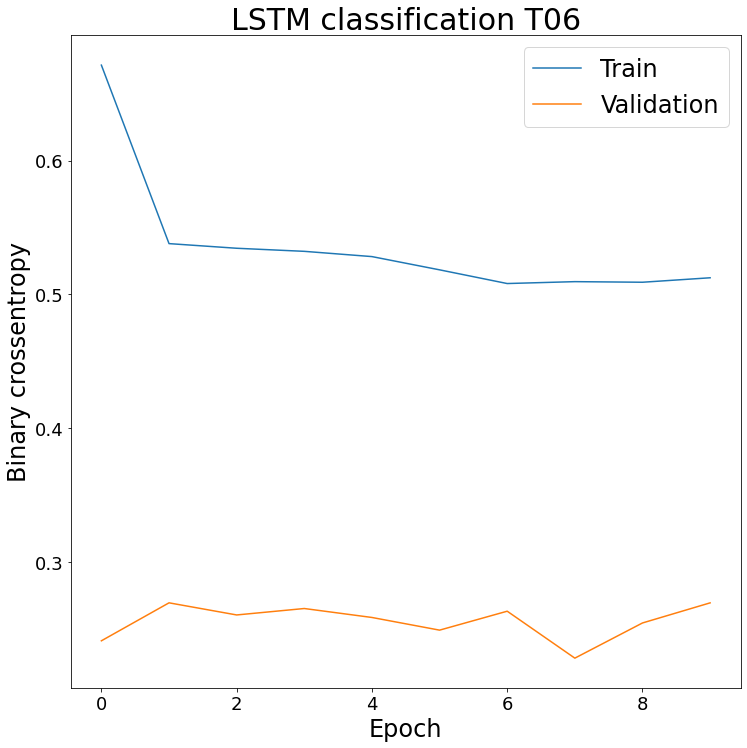

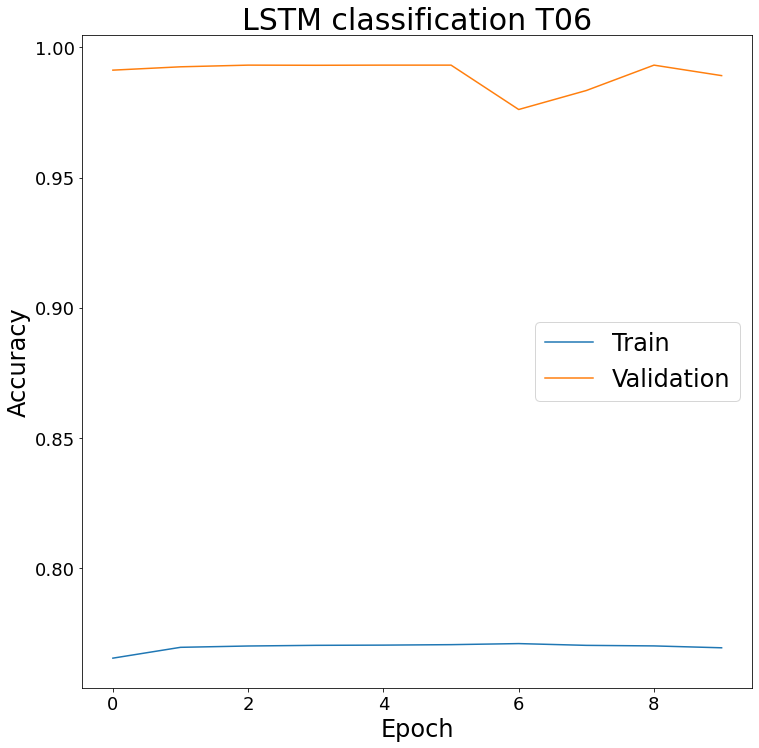

Epoch 1/10
880/880 [==============================] - 5s 3ms/step - loss: 0.6440 - accuracy: 0.7738 - val_loss: 0.2691 - val_accuracy: 0.9184
Epoch 2/10
880/880 [==============================] - 1s 2ms/step - loss: 0.3669 - accuracy: 0.8231 - val_loss: 0.1066 - val_accuracy: 0.9582
Epoch 3/10
880/880 [==============================] - 1s 2ms/step - loss: 0.3074 - accuracy: 0.8528 - val_loss: 0.1786 - val_accuracy: 0.9005
Epoch 4/10
880/880 [==============================] - 1s 2ms/step - loss: 0.2948 - accuracy: 0.8635 - val_loss: 0.1802 - val_accuracy: 0.9011
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2891 - accuracy: 0.8579 - val_loss: 0.1898 - val_accuracy: 0.8492
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3277 - accuracy: 0.8488 - val_loss: 0.1418 - val_accuracy: 0.8748
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.3579 - accuracy: 0.8545 - val_loss: 0.1654 - val_accuracy: 0.8388
Epoch 

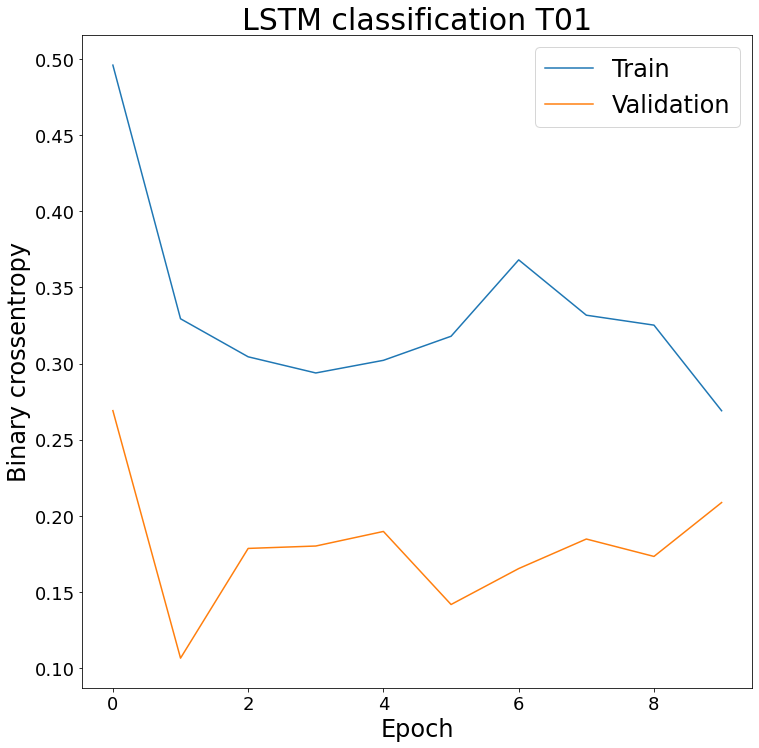

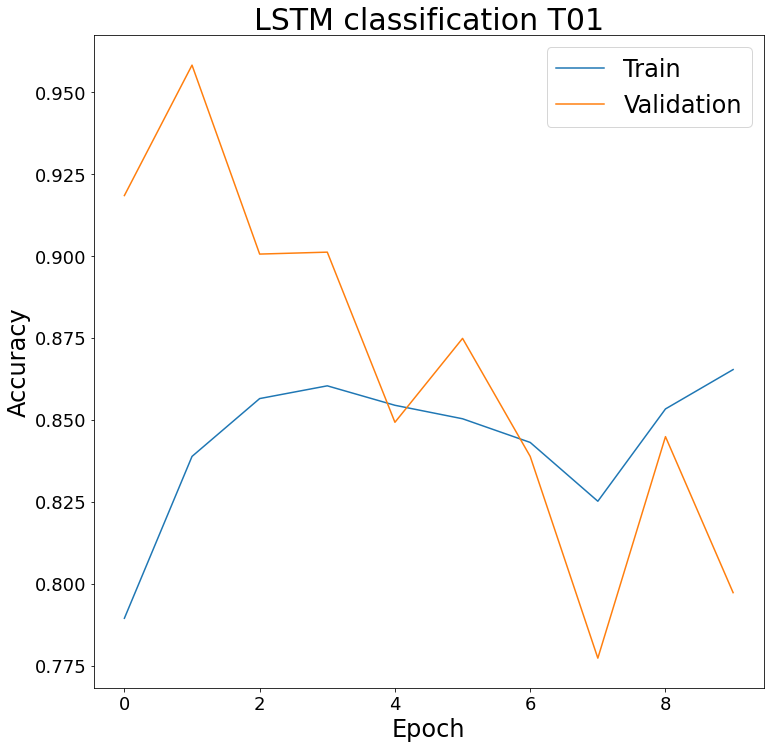

Epoch 1/10
581/581 [==============================] - 3s 2ms/step - loss: 1.0069 - accuracy: 0.7633 - val_loss: 0.2820 - val_accuracy: 0.9908
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5718 - accuracy: 0.7659 - val_loss: 0.2480 - val_accuracy: 0.9930
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5382 - accuracy: 0.7669 - val_loss: 0.2816 - val_accuracy: 0.9883
Epoch 4/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5413 - accuracy: 0.7670 - val_loss: 0.2357 - val_accuracy: 0.9898
Epoch 5/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5322 - accuracy: 0.7700 - val_loss: 0.2629 - val_accuracy: 0.9874
Epoch 6/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5190 - accuracy: 0.7724 - val_loss: 0.2629 - val_accuracy: 0.9818
Epoch 7/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5171 - accuracy: 0.7699 - val_loss: 0.2595 - val_accuracy: 0.9918
Epoch 

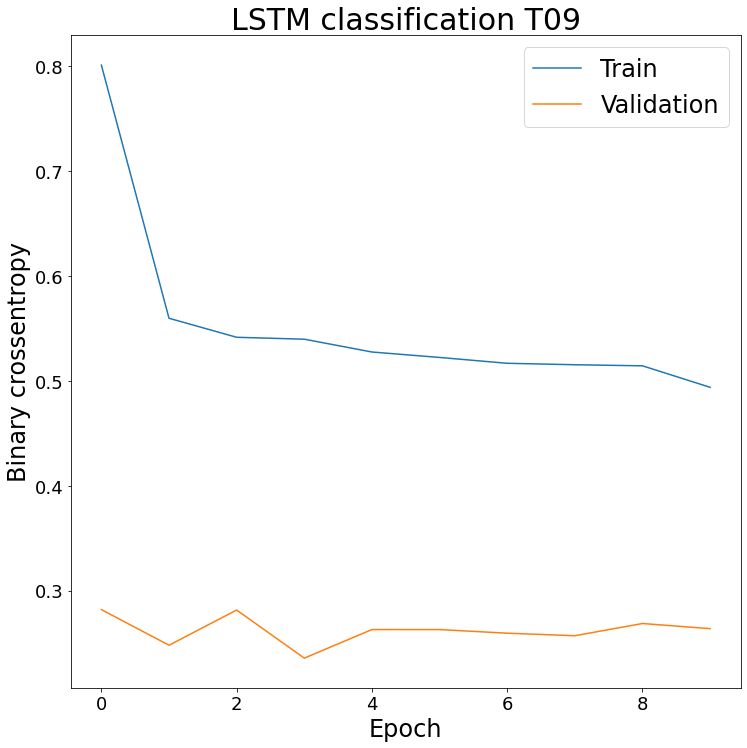

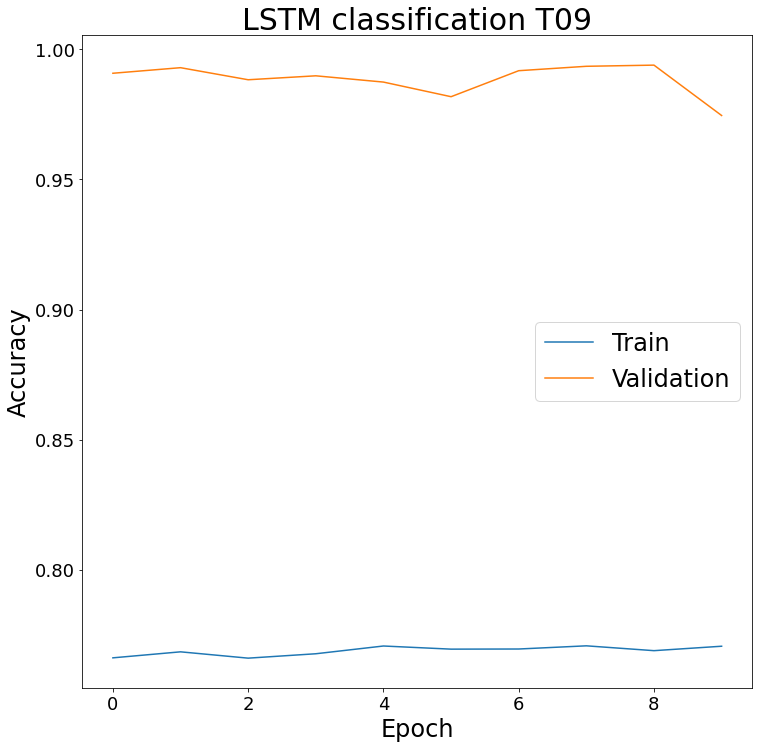

Epoch 1/10
892/892 [==============================] - 4s 2ms/step - loss: 1.3976 - accuracy: 0.7369 - val_loss: 0.2613 - val_accuracy: 0.9928
Epoch 2/10
892/892 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7683 - val_loss: 0.2369 - val_accuracy: 0.9947
Epoch 3/10
892/892 [==============================] - 2s 2ms/step - loss: 0.5325 - accuracy: 0.7697 - val_loss: 0.2346 - val_accuracy: 0.9947
Epoch 4/10
892/892 [==============================] - 2s 2ms/step - loss: 0.5268 - accuracy: 0.7712 - val_loss: 0.2361 - val_accuracy: 0.9939
Epoch 5/10
892/892 [==============================] - 2s 2ms/step - loss: 0.5331 - accuracy: 0.7695 - val_loss: 0.2324 - val_accuracy: 0.9838
Epoch 6/10
892/892 [==============================] - 2s 2ms/step - loss: 0.5543 - accuracy: 0.7665 - val_loss: 0.2479 - val_accuracy: 0.9901
Epoch 7/10
892/892 [==============================] - 2s 2ms/step - loss: 0.4907 - accuracy: 0.7701 - val_loss: 0.2214 - val_accuracy: 0.9501
Epoch 

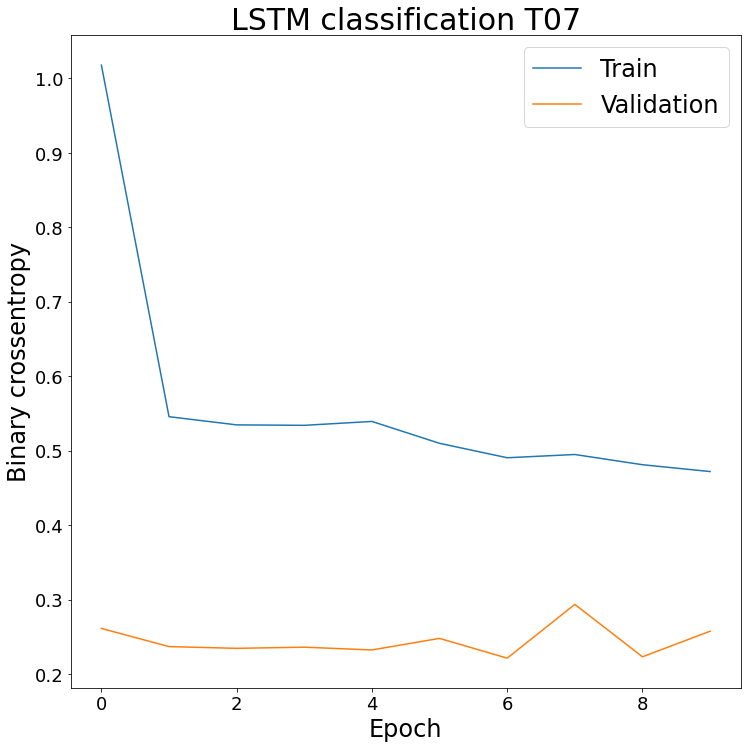

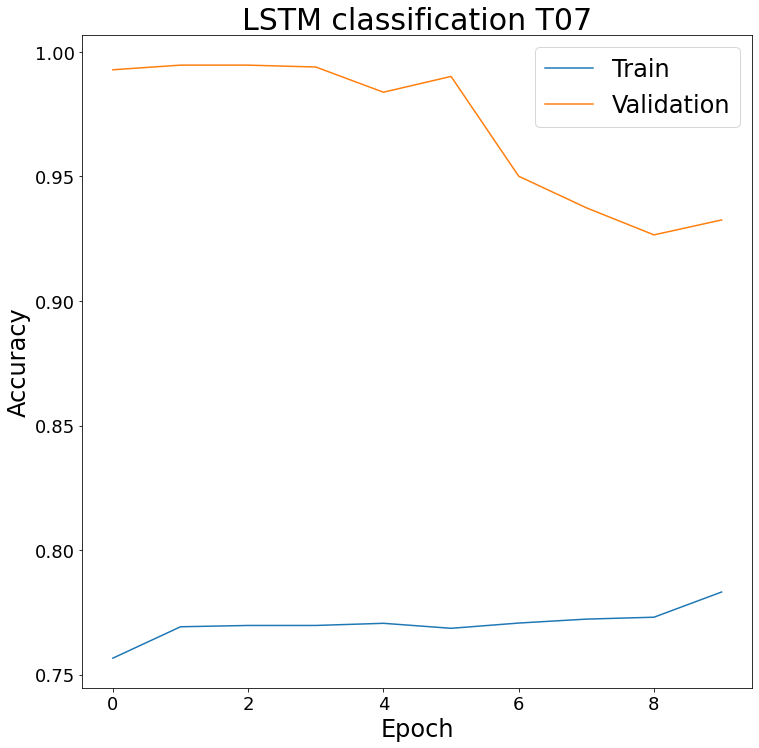

In [14]:
turbines=data.Turbine_ID.unique()
for turbine in turbines:
    data_=data_cl(data,30,12,turbine,True,72)
    X_train=data_[0]
    X_test=data_[1]
    y_train=data_[2]
    y_test=data_[3]
    LSTMcl(X_train,X_test,y_train,y_test)